In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from DataTransformation import LowPassFilter, PrincipalComponentAnalysis
from TemporalAbstraction import NumericalAbstraction
from FrequencyAbstraction import FourierTransformation
from sklearn.cluster import KMeans

# 1. Đọc file dữ liệu

In [94]:
df = pd.read_pickle("../../data/interim/02_outliers_removed_chauvenets.pkl")

predictor_columns = list(df.columns[:6])

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22356 entries, 2019-01-11 15:08:05.280000 to 2019-01-20 17:33:27.760000
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   acc_x        22356 non-null  float64
 1   acc_y        22356 non-null  float64
 2   acc_z        22356 non-null  float64
 3   gyr_x        22356 non-null  float64
 4   gyr_y        22356 non-null  float64
 5   gyr_z        22356 non-null  float64
 6   participant  22356 non-null  object 
 7   label        22356 non-null  object 
 8   category     22356 non-null  object 
 9   set          22356 non-null  int32  
dtypes: float64(6), int32(1), object(3)
memory usage: 1.8+ MB


In [76]:
# Plot settings
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["axes.facecolor"] = 'white'  
plt.rcParams["figure.facecolor"] = 'white'

# 2. Lọc thông thấp bằng Butterworth lowpass filter

## 2.1. Áp dụng trên 1 chiều dữ liệu

dead


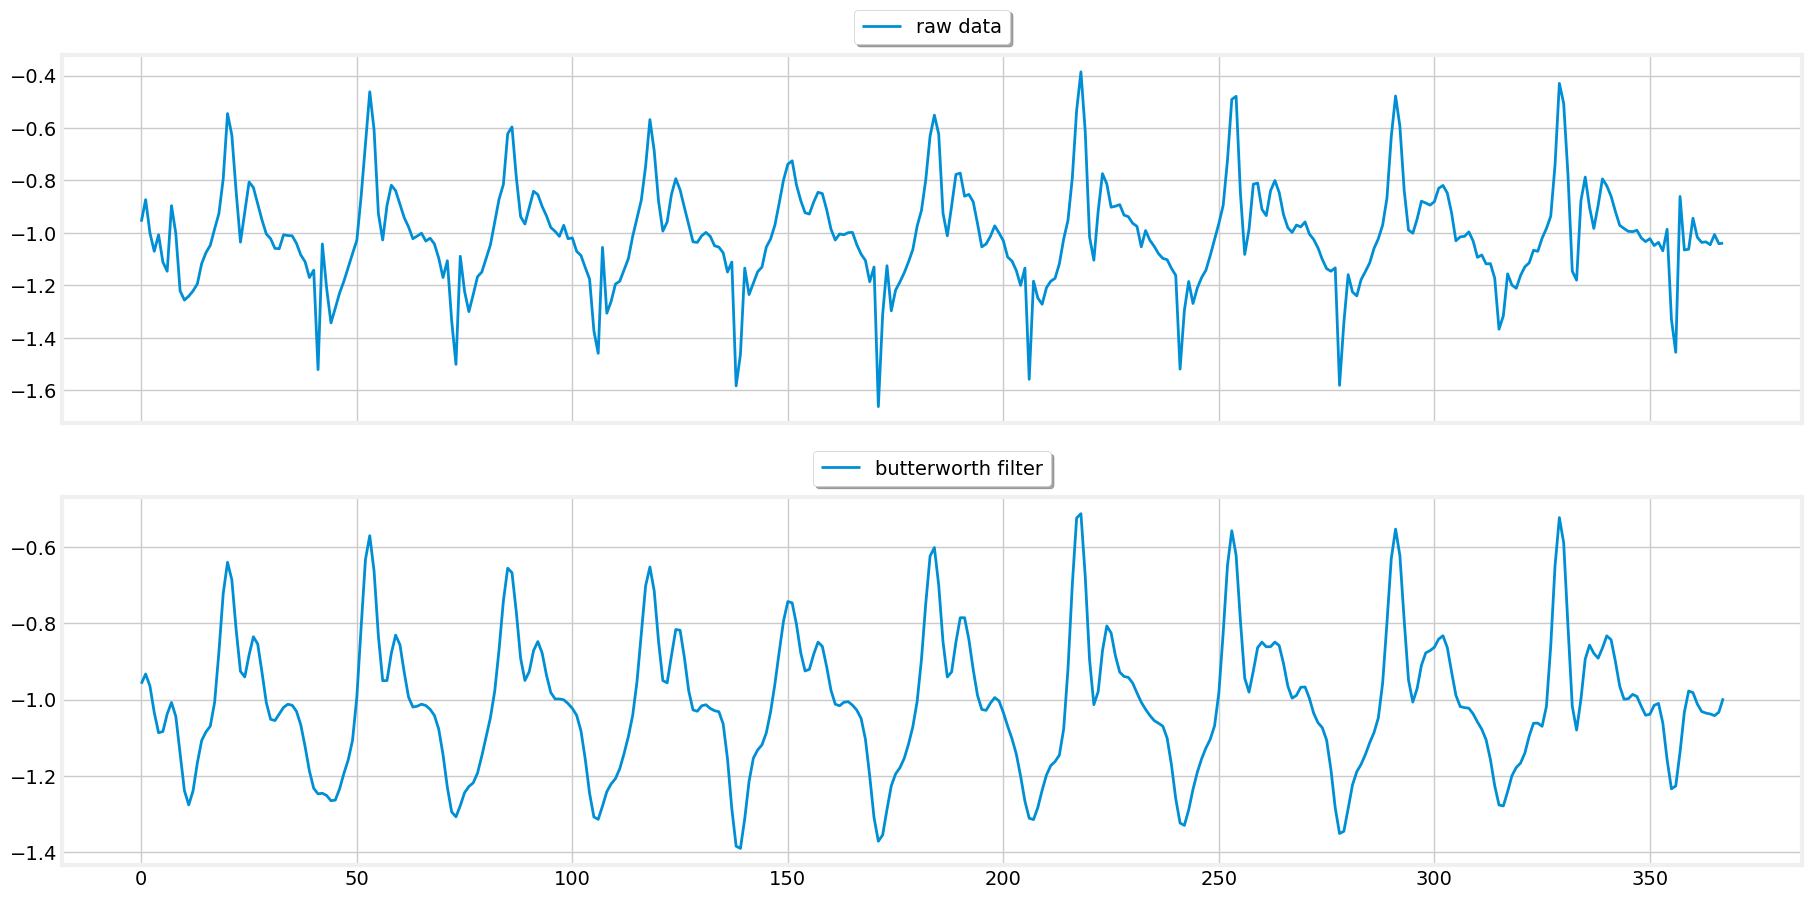

In [77]:
df_lowpass = df.copy()
LowPass = LowPassFilter()

fs = 12.5
cutoff = 2.3

df_lowpass = LowPass.low_pass_filter(df_lowpass, "acc_y", fs, cutoff, order=5)

subset = df_lowpass[df_lowpass["set"] == 44]
print(subset["label"].iloc[0])

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(20, 10))
ax[0].plot(subset["acc_y"].reset_index(drop=True), label="raw data")
ax[1].plot(subset["acc_y_lowpass"].reset_index(drop=True), label="butterworth filter")
ax[0].legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), fancybox=True, shadow=True)
ax[1].legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), fancybox=True, shadow=True)

## 2.2. Áp dụng trên toàn bộ dữ liệu

In [78]:
for col in predictor_columns:
    df_lowpass = LowPass.low_pass_filter(df_lowpass, col, fs, cutoff, order=5)
    df_lowpass[col] = df_lowpass[col + "_lowpass"]
    del df_lowpass[col + "_lowpass"]

# 3. Giảm chiều dữ liệu bằng PCA

## 3.1. Tìm số K tối ưu

In [79]:
df_pca = df_lowpass.copy()
PCA = PrincipalComponentAnalysis()

pc_values = PCA.determine_pc_explained_variance(df_pca, predictor_columns)

pc_values

array([0.55989062, 0.27960662, 0.06432699, 0.06128687, 0.01963934,
       0.01524957])

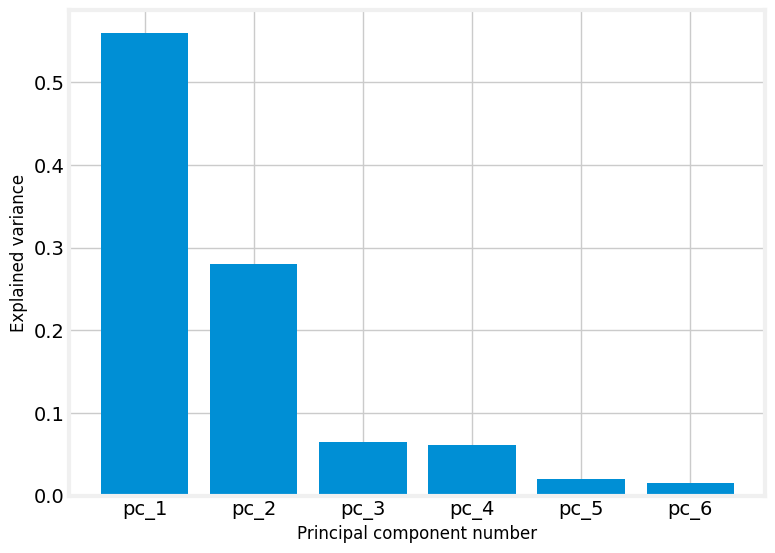

In [80]:
# Biểu diễn dữ liệu 
z = ["pc_1", "pc_2", "pc_3", "pc_4", "pc_5", "pc_6"]
plt.figure(figsize=(8, 6))
plt.bar(z, pc_values)
plt.xlabel("Principal component number", fontsize=12)
plt.ylabel("Explained variance", fontsize=12)
plt.show()

## 3.2. Áp dụng PCA

In [81]:
df_pca = PCA.apply_pca(df_pca, predictor_columns, 3)

df_pca

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,pc_1,pc_2,pc_3
epoch (ms),,,,,,,,,,,,,
2019-01-11 15:08:05.280,0.016019,0.979950,-0.086979,8.169378,-7.064749,8.112952,B,bench,heavy,30,-0.292561,-0.083584,0.057362
2019-01-11 15:08:05.360,0.005643,0.974604,-0.077288,1.031061,-1.523039,4.546367,B,bench,heavy,30,-0.291544,-0.079735,0.029952
2019-01-11 15:08:05.440,0.001325,0.973850,-0.069637,-4.071692,0.983106,3.130092,B,bench,heavy,30,-0.291524,-0.076052,0.010243
2019-01-11 15:08:05.520,0.003177,0.977044,-0.065388,-5.464630,0.276350,3.510996,B,bench,heavy,30,-0.292300,-0.073306,0.004838
2019-01-11 15:08:05.600,0.005462,0.978996,-0.064747,-2.664486,-1.449411,3.216054,B,bench,heavy,30,-0.292686,-0.072579,0.015894
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.440,-0.049278,-1.022628,-0.065363,1.108011,-3.459099,1.246198,E,row,medium,90,0.332208,-0.141283,-0.026255
2019-01-20 17:33:27.520,-0.048017,-1.031092,-0.062472,1.787031,-1.766199,0.716985,E,row,medium,90,0.335039,-0.139700,-0.023595
2019-01-20 17:33:27.600,-0.044053,-1.035872,-0.055673,1.157009,0.145149,0.650340,E,row,medium,90,0.336996,-0.135407,-0.025860


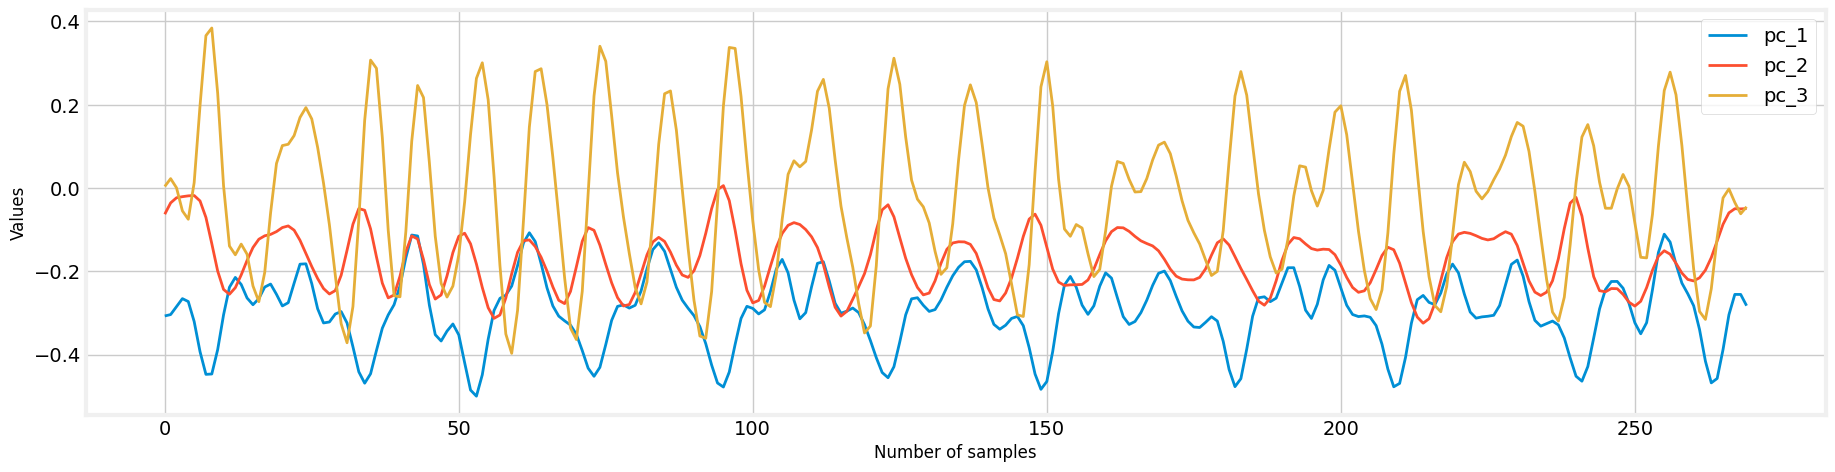

In [82]:
# Biểu diễn PCA
subset = df_pca[df_pca["set"] == 35].reset_index(drop=True)
ax = subset[["pc_1", "pc_2", "pc_3"]].plot()
ax.set_xlabel("Number of samples", fontsize=12)
ax.set_ylabel("Values", fontsize=12)
plt.show()

# 4. Thêm chiều dữ liệu r

array([<AxesSubplot: xlabel='epoch (ms)'>,
       <AxesSubplot: xlabel='epoch (ms)'>], dtype=object)

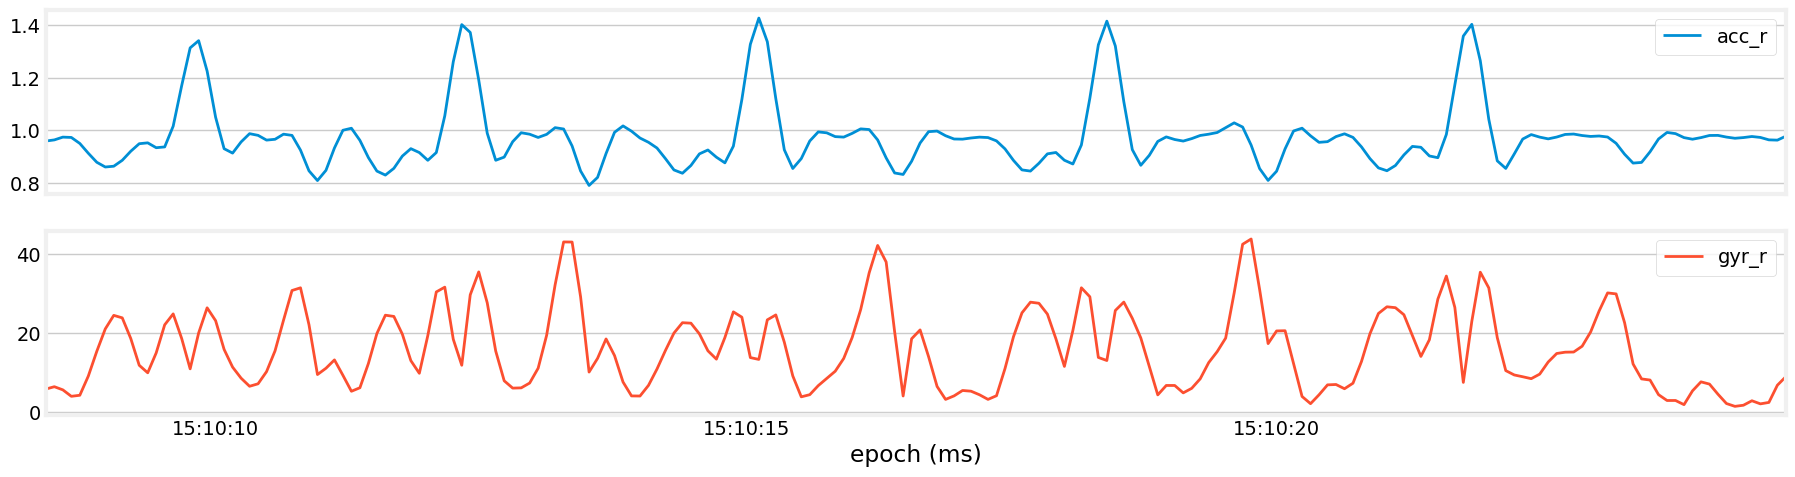

In [83]:
df_squared = df_pca.copy()

acc_r = df_squared["acc_x"] ** 2 + df_squared["acc_y"] ** 2 + df_squared["acc_z"] ** 2
gyr_r = df_squared["gyr_x"] ** 2 + df_squared["gyr_y"] ** 2 + df_squared["gyr_z"] ** 2

df_squared["acc_r"] = np.sqrt(acc_r)
df_squared["gyr_r"] = np.sqrt(gyr_r)

subset = df_squared[df_pca["set"] == 1]

subset[["acc_r", "gyr_r"]].plot(subplots=True)

In [84]:
# Tính chu kỳ trung bình của 1 rep tập
for s in df["set"].unique():
    start = df[df["set"] == s].index[0]
    stop = df[df["set"] == s].index[-1]

    duration = stop - start
    df.loc[(df["set"] == s), "duration"] = duration.seconds

duration_df = df.groupby(["category"])["duration"].mean()

duration_df


category
heavy       14.679566
medium      24.869620
sitting     33.000000
standing    39.000000
Name: duration, dtype: float64

In [85]:
# Chu kỳ trung bình của 1 rep tập
(duration_df.iloc[0] / 5 + duration_df.iloc[1] / 10) / 2

2.711437662453913

# 5. Temporal abstraction

In [86]:
df_temporal = df_squared.copy()
NumAbs = NumericalAbstraction()

predictor_columns = predictor_columns + ["acc_r", "gyr_r"]

ws = int(2.8 * 12.5)

df_temporal_list = []
for s in df_temporal["set"].unique():
    subset = df_temporal[df_temporal["set"] == s].copy()
    for col in predictor_columns:
        subset = NumAbs.abstract_numerical(subset, [col], ws, "mean")
        subset = NumAbs.abstract_numerical(subset, [col], ws, "std")
    df_temporal_list.append(subset)

df_temporal = pd.concat(df_temporal_list)

In [87]:
df_temporal.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22356 entries, 2019-01-11 15:08:05.280000 to 2019-01-20 17:33:27.760000
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   acc_x                  22356 non-null  float64
 1   acc_y                  22356 non-null  float64
 2   acc_z                  22356 non-null  float64
 3   gyr_x                  22356 non-null  float64
 4   gyr_y                  22356 non-null  float64
 5   gyr_z                  22356 non-null  float64
 6   participant            22356 non-null  object 
 7   label                  22356 non-null  object 
 8   category               22356 non-null  object 
 9   set                    22356 non-null  int32  
 10  pc_1                   22356 non-null  float64
 11  pc_2                   22356 non-null  float64
 12  pc_3                   22356 non-null  float64
 13  acc_r                  22356 non-null  float64
 14  gyr_r

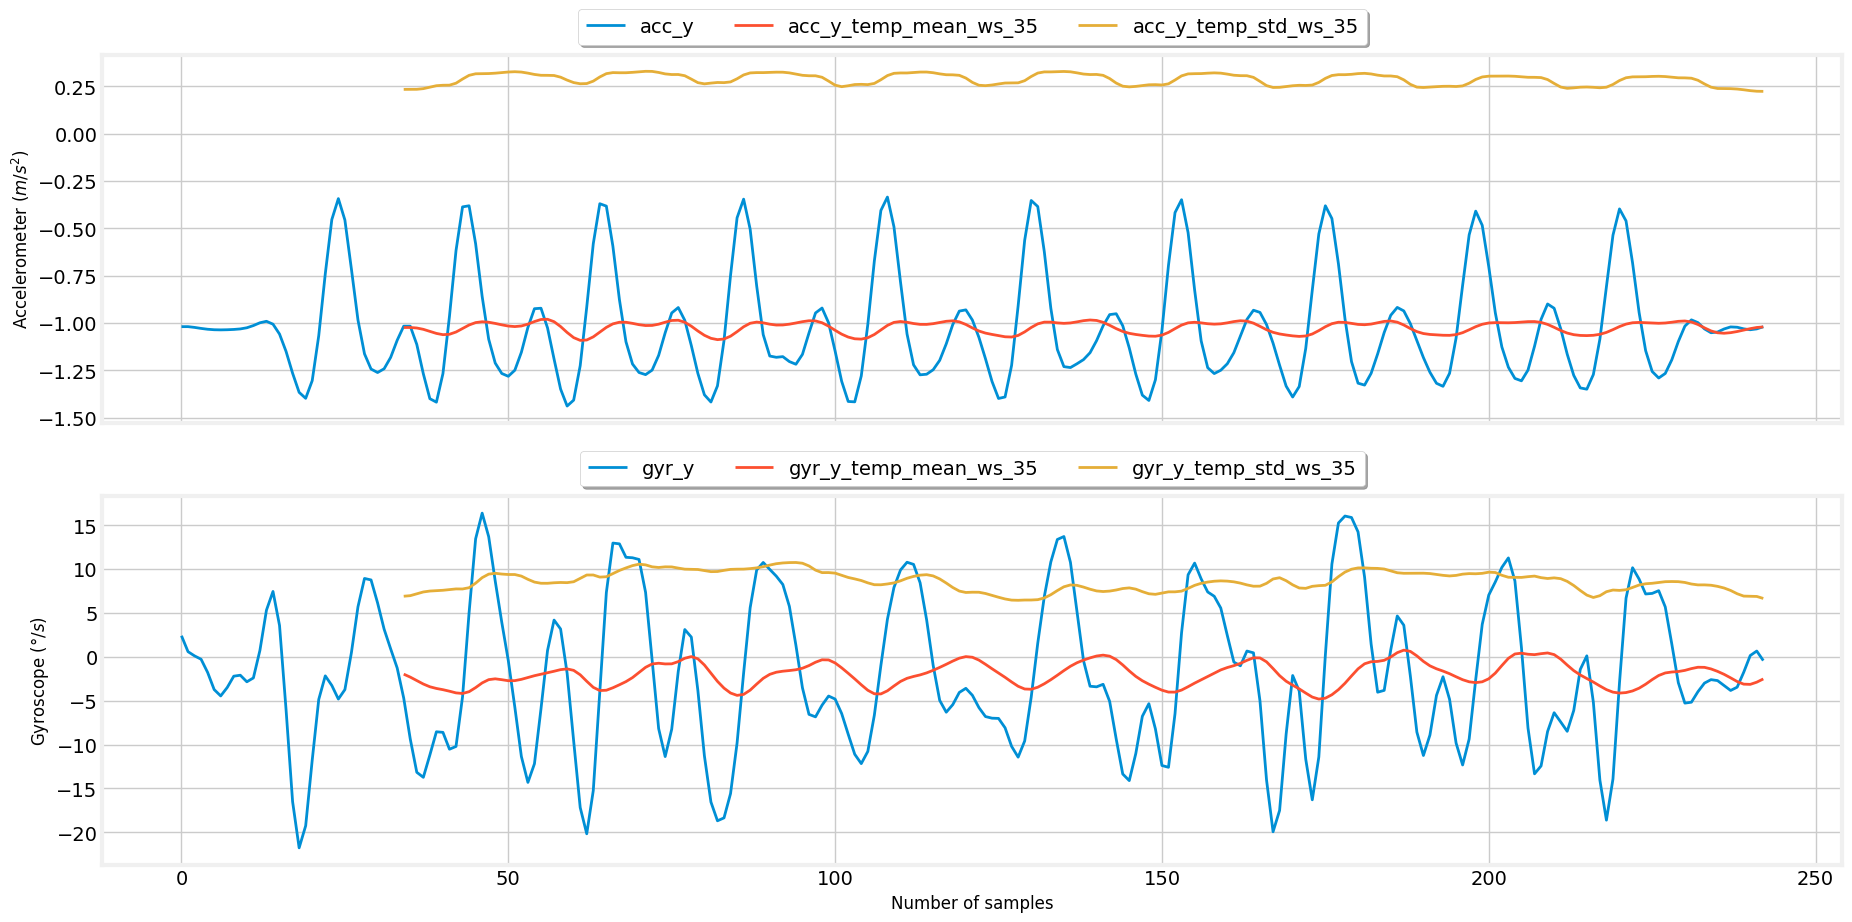

In [88]:
subset = subset.reset_index(drop=True)

if len(subset) > 0:    
    fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(20, 10))
    subset[["acc_y", "acc_y_temp_mean_ws_35", "acc_y_temp_std_ws_35"]].plot(ax=ax[0])
    subset[["gyr_y", "gyr_y_temp_mean_ws_35", "gyr_y_temp_std_ws_35"]].plot(ax=ax[1])

    ax[0].legend(
        loc="upper center",
        bbox_to_anchor=(0.5, 1.15),
        ncol=3,
        fancybox=True,
        shadow=True,
    )
    ax[0].set_ylabel("Accelerometer ($m/s^2$)", fontsize=12)
        
    ax[1].legend(
        loc="upper center",
        bbox_to_anchor=(0.5, 1.15),
        ncol=3,
        fancybox=True,
        shadow=True,
    )
    ax[1].set_xlabel("Number of samples", fontsize=12)
    ax[1].set_ylabel("Gyroscope ($\degree/s$)", fontsize=12)

# 6. Discrete Fourier Transformation

In [89]:
df_freq = df_temporal.copy().reset_index()
FreqAbs = FourierTransformation()

fs = 12.5
ws = int(16)

df_freq = FreqAbs.abstract_frequency(df_freq, ["acc_y"], ws, fs)

df_freq.columns

Index(['epoch (ms)', 'acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z',
       'participant', 'label', 'category', 'set', 'pc_1', 'pc_2', 'pc_3',
       'acc_r', 'gyr_r', 'acc_x_temp_mean_ws_35', 'acc_x_temp_std_ws_35',
       'acc_y_temp_mean_ws_35', 'acc_y_temp_std_ws_35',
       'acc_z_temp_mean_ws_35', 'acc_z_temp_std_ws_35',
       'gyr_x_temp_mean_ws_35', 'gyr_x_temp_std_ws_35',
       'gyr_y_temp_mean_ws_35', 'gyr_y_temp_std_ws_35',
       'gyr_z_temp_mean_ws_35', 'gyr_z_temp_std_ws_35',
       'acc_r_temp_mean_ws_35', 'acc_r_temp_std_ws_35',
       'gyr_r_temp_mean_ws_35', 'gyr_r_temp_std_ws_35', 'acc_y_max_freq',
       'acc_y_freq_weighted', 'acc_y_pse', 'acc_y_freq_0.0_Hz_ws_16',
       'acc_y_freq_0.781_Hz_ws_16', 'acc_y_freq_1.562_Hz_ws_16',
       'acc_y_freq_2.344_Hz_ws_16', 'acc_y_freq_3.125_Hz_ws_16',
       'acc_y_freq_3.906_Hz_ws_16', 'acc_y_freq_4.688_Hz_ws_16',
       'acc_y_freq_5.469_Hz_ws_16', 'acc_y_freq_6.25_Hz_ws_16'],
      dtype='object')

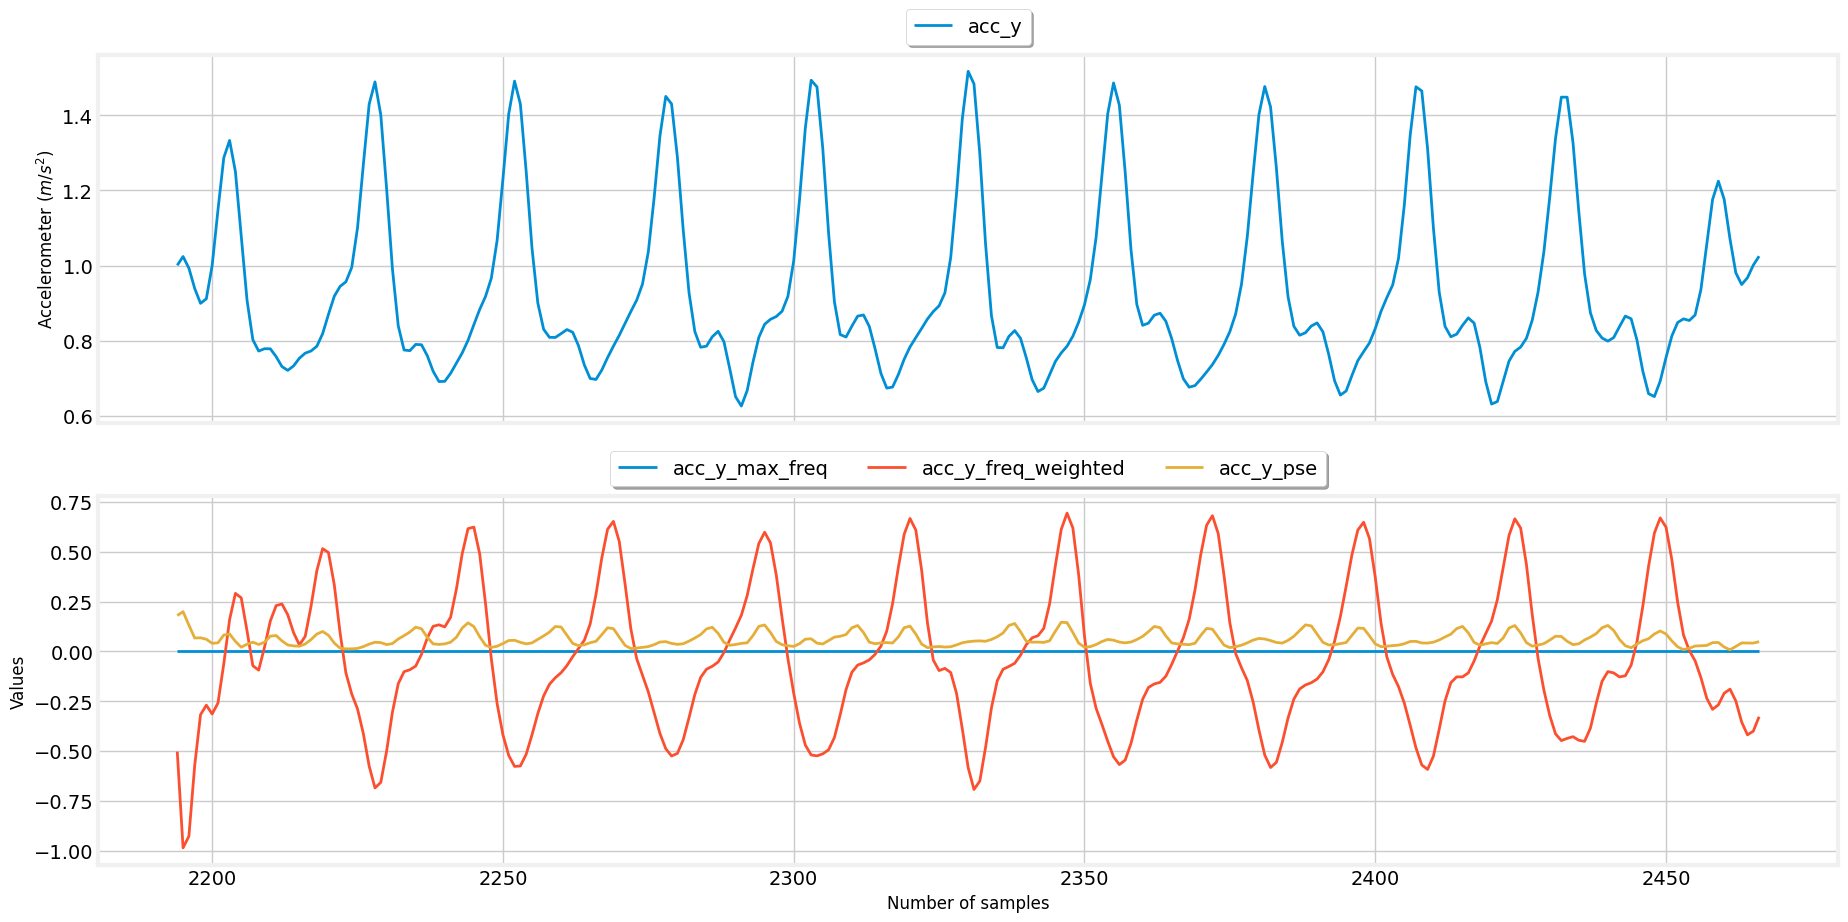

In [90]:
# Visualize results
subset = df_freq[df_freq["set"] == 15]

if len(subset) > 0:    
    fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(20, 10))
    subset[["acc_y"]].plot(ax=ax[0])
    subset[
        [
            "acc_y_max_freq",
            "acc_y_freq_weighted",
            "acc_y_pse"
        ]
    ].plot(ax=ax[1])

    ax[0].legend(
        loc="upper center",
        bbox_to_anchor=(0.5, 1.15),
        ncol=3,
        fancybox=True,
        shadow=True,
    )
    ax[0].set_ylabel("Accelerometer ($m/s^2$)", fontsize=12)
        
    ax[1].legend(
        loc="upper center",
        bbox_to_anchor=(0.5, 1.15),
        ncol=3,
        fancybox=True,
        shadow=True,
    )
    ax[1].set_xlabel("Number of samples", fontsize=12)
    ax[1].set_ylabel("Values", fontsize=12)

In [91]:
df_freq_list = []
for s in df_freq["set"].unique():
    print(f"Applying Fourier transformations to set {s}")
    subset = df_freq[df_freq["set"] == s].reset_index(drop=True).copy()
    subset = FreqAbs.abstract_frequency(subset, predictor_columns, ws, fs)
    df_freq_list.append(subset)

df_freq = pd.concat(df_freq_list).set_index("epoch (ms)", drop=True)

Applying Fourier transformations to set 30
Applying Fourier transformations to set 1
Applying Fourier transformations to set 31
Applying Fourier transformations to set 3
Applying Fourier transformations to set 9
Applying Fourier transformations to set 32
Applying Fourier transformations to set 10
Applying Fourier transformations to set 33
Applying Fourier transformations to set 11
Applying Fourier transformations to set 34
Applying Fourier transformations to set 35
Applying Fourier transformations to set 15
Applying Fourier transformations to set 36
Applying Fourier transformations to set 16
Applying Fourier transformations to set 37
Applying Fourier transformations to set 17
Applying Fourier transformations to set 27
Applying Fourier transformations to set 38
Applying Fourier transformations to set 28
Applying Fourier transformations to set 29
Applying Fourier transformations to set 6
Applying Fourier transformations to set 65
Applying Fourier transformations to set 67
Applying Fourie

In [92]:
df_freq = df_freq.dropna()
df_freq.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19262 entries, 2019-01-11 15:08:08 to 2019-01-20 17:33:27.760000
Columns: 127 entries, acc_x to gyr_r_freq_6.25_Hz_ws_16
dtypes: float64(123), int32(1), object(3)
memory usage: 18.7+ MB


# 8. Xuất file dữ liệu

In [93]:
df_freq.to_pickle("../../data/interim/03_data_features.pkl")